In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install tabulate

In [3]:
root_dir_bach2018 = "/kaggle/input/bach-2018/Photos/"
annotations_file = "microscopy_ground_truth.csv"

In [4]:
df_b = pd.read_csv(os.path.join(root_dir_bach2018, annotations_file))
df_b.head()

,n001.tif,Normal
0,n002.tif,Normal
1,n003.tif,Normal
2,n004.tif,Normal
3,n005.tif,Normal
4,n006.tif,Normal


In [5]:
# Read the annotations file without a header
data = pd.read_csv(os.path.join(root_dir_bach2018, annotations_file), header=None, names=['filename', 'class'])

# Count the number of images in each class
class_counts = data['class'].value_counts()

# Create a DataFrame for the counts
counts_df = pd.DataFrame({
    'Class': "Number of samples of " + class_counts.index + " class",
    'Count': class_counts.values
})

# Add the total count row using pd.concat
total_count_df = pd.DataFrame({'Class': ['Total images'], 'Count': [class_counts.sum()]})
counts_df = pd.concat([counts_df, total_count_df], ignore_index=True)

# Display the table with borders
print(counts_df.to_markdown(index=False, tablefmt="grid"))

+-------------------------------------+---------+
| Class                               |   Count |
+=====================================+=========+
| Number of samples of Normal class   |     100 |
+-------------------------------------+---------+
| Number of samples of Benign class   |     100 |
+-------------------------------------+---------+
| Number of samples of InSitu class   |     100 |
+-------------------------------------+---------+
| Number of samples of Invasive class |     100 |
+-------------------------------------+---------+
| Total images                        |     400 |
+-------------------------------------+---------+


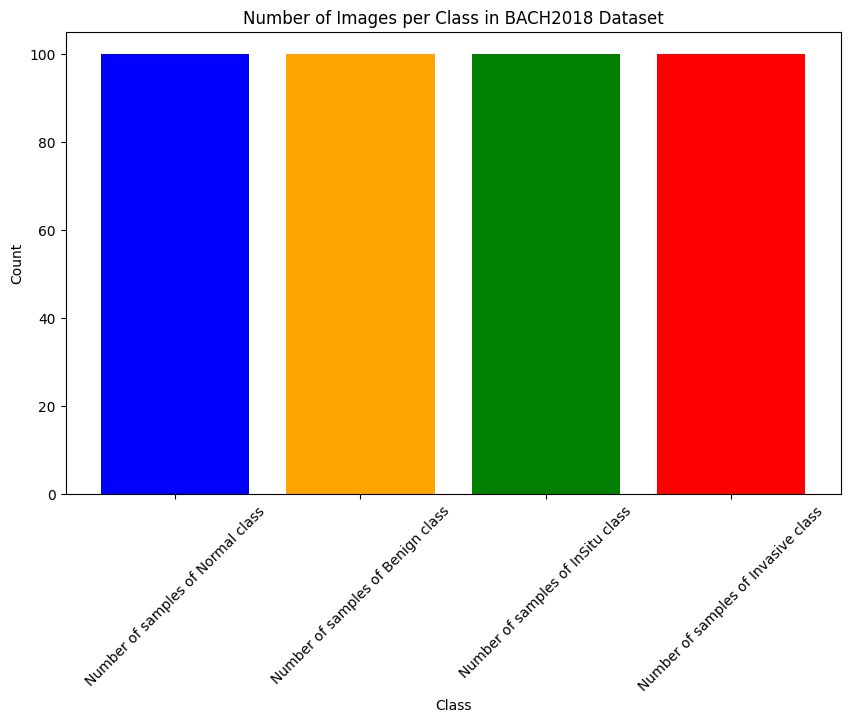

In [6]:
# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(counts_df['Class'][:-1], counts_df['Count'][:-1], color=['blue', 'orange', 'green', 'red'])  # Exclude 'Total images' for the bar graph
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class in BACH2018 Dataset')
plt.xticks(rotation=45)
plt.show()

In [7]:
!pip install patchify

In [8]:
import cv2
from skimage import io
from skimage.color import rgb2lab, lab2rgb


def reinhard_normalization(source, target):
    """
    Apply Reinhard stain normalization to the source image using the target image.
    """
    # Convert images to LAB color space
    source_lab = rgb2lab(source)
    target_lab = rgb2lab(target)

    # Calculate mean and standard deviation for each channel
    source_mean, source_std = source_lab.mean(axis=(0, 1)), source_lab.std(axis=(0, 1))
    target_mean, target_std = target_lab.mean(axis=(0, 1)), target_lab.std(axis=(0, 1))

    # Normalize each channel
    norm_lab = (source_lab - source_mean) / source_std * target_std + target_mean

    # Convert back to RGB color space
    norm_rgb = lab2rgb(norm_lab)
    norm_rgb = (norm_rgb * 255).astype(np.uint8)

    return norm_rgb

In [9]:
# List of source images
source_images = ['/kaggle/input/bach-2018/Photos/Benign/b001.tif', '/kaggle/input/bach-2018/Photos/InSitu/is001.tif',
                 '/kaggle/input/bach-2018/Photos/Invasive/iv001.tif', '/kaggle/input/bach-2018/Photos/Normal/n001.tif']
target_image = io.imread('/kaggle/input/bach-2018/Photos/Benign/b009.tif')

# Apply normalization to each source image
normalized_images = []
for source_path in source_images:
    source_image = io.imread(source_path)
    normalized_image = reinhard_normalization(source_image, target_image)
    normalized_images.append(normalized_image)

In [30]:

from patchify import patchify

class Bach2018Dataset(Dataset):
    def __init__(self, root_dir, target_image_path, split='train', transform=None, patch_size=(224, 224), seed=42, mode='patch'):
        self.root_dir = root_dir
        self.transform = transform
        self.patch_size = patch_size
        self.split = split
        self.mode = mode
        self.data = self._load_data(seed)
        self.target_image = io.imread(target_image_path)

    def _load_data(self, seed):
        random.seed(seed)
        data = []
        classes = ['Normal', 'Benign', 'InSitu', 'Invasive']
        for class_name in classes:
            class_dir = os.path.join(self.root_dir, class_name)
            images = [img for img in os.listdir(class_dir) if img.endswith('.tif')]
            # images = os.listdir(class_dir)
            random.shuffle(images)
            if self.split == 'train':
                images = images[:60]
            elif self.split == 'val':
                images = images[60:80]
            elif self.split == 'test':
                images = images[80:100]
            for img in images:
                data.append((img, class_name))
        return pd.DataFrame(data, columns=['filename', 'class'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and label
        class_name = self.data.iloc[idx]['class']
        img_path = os.path.join(self.root_dir, class_name, self.data.iloc[idx]['filename'])
        label = self.get_label(class_name)

        # Load and convert the image
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        # Apply Reinhard normalization
        image = reinhard_normalization(image, self.target_image)

        if self.mode == 'patch':
            # Ensure the image dimensions are multiples of the patch size
            # Ensure the image dimensions are multiples of the patch size
            SIZE_X = (image.shape[0] // self.patch_size[1]) * self.patch_size[1]  # Nearest patch size for width
            SIZE_Y = (image.shape[1] // self.patch_size[0]) * self.patch_size[0]  # Nearest patch size for height

            # Crop the image
            image = image[:SIZE_X, :SIZE_Y, :]

            # Divide the image into patches using patchify with 50% overlap
            step_size = (self.patch_size[0] // 2, self.patch_size[1] // 2, 3)
            patches = patchify(image, (self.patch_size[0], self.patch_size[1], 3), step=step_size)
            patches = patches.reshape(-1, self.patch_size[0], self.patch_size[1], 3)

            augmented_patches = []
            for patch in patches:
                patch_img = Image.fromarray(patch)
                if self.transform:
                    for _ in range(6):  # Apply the transform 6 times (1 original + 5 augmented)
                        augmented_patches.append(self.transform(patch_img))
                else:
                    augmented_patches.append(transforms.ToTensor()(patch_img))

            return torch.stack(augmented_patches), torch.tensor(label)
        else:
            # Resize the image to (512, 512)
            image = Image.fromarray(image).resize(self.patch_size)
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
            return image, torch.tensor(label)

    def get_label(self, class_name):
        class_dict = {'Normal': 0, 'Benign': 1, 'InSitu': 2, 'Invasive': 3}
        return class_dict[class_name]

In [31]:
import torchvision.transforms as transforms


# Define the transform
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.RandomVerticalFlip(p=1.0),
            transforms.RandomChoice([
                transforms.RandomRotation(degrees=(90, 90)),
                transforms.RandomRotation(degrees=(180, 180)),
                transforms.RandomRotation(degrees=(270, 270))
            ]),
            transforms.ToTensor()
        ])

    def __call__(self, img):
        img = self.transforms(img)
        # img = self.normalize(img)
        return img

    def normalize(self, img):
        # Normalize by subtracting the average value of each channel
        mean = img.mean(dim=(1, 2), keepdim=True)
        img = img - mean
        return img

# Apply the transform to the patches
custom_transform = CustomTransform()

In [32]:
target_image_path = '/kaggle/input/bach-2018/Photos/Benign/b009.tif'
bach_dset = Bach2018Dataset(root_dir_bach2018, target_image_path, split='train', transform=custom_transform, patch_size=(512, 512), seed=42, mode='image')
# img, label = bach_dset[30]
# Get the 4th image (index 3)
img, label = bach_dset[239]

# Count the number of patches
# num_patches = patches.size(0)
img_shape = img.shape

print(f"img_shape: {img_shape}")


img_shape: torch.Size([3, 512, 512])


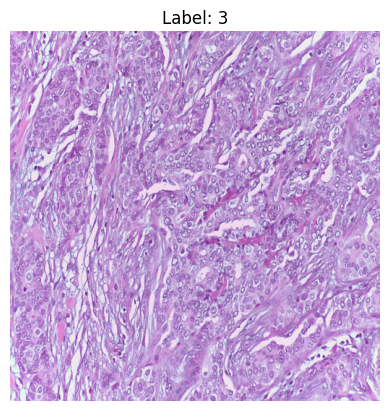

In [33]:
label = label.item()

img = img.numpy().transpose((1, 2, 0))

# Display the image with the label
plt.imshow(img)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

240


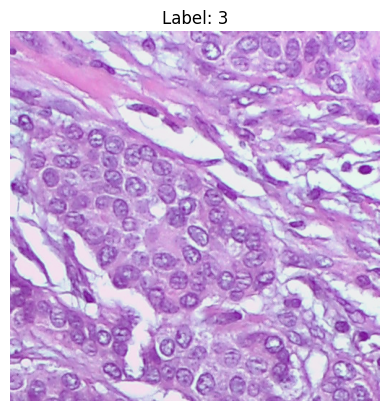

In [37]:
target_image_path = '/kaggle/input/bach-2018/Photos/Benign/b009.tif'
bach_dset = Bach2018Dataset(root_dir_bach2018, target_image_path, split='train', transform=custom_transform, patch_size=(512, 512), seed=42, mode='patch')

print(len(bach_dset))
patches, label = bach_dset[239]

# Display the first patch
first_patch = patches[2].permute(1, 2, 0).numpy()  # Convert from tensor to numpy array and rearrange dimensions
plt.imshow(first_patch)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [48]:
bach2018_loader = DataLoader(bach_dset, batch_size=25, shuffle=True)

In [49]:
def display_images(dataset, class_names, mode = 'patch', num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(15, 15))
    fig.suptitle('Images from the 4 Classes', fontsize=20)

    for i, class_name in enumerate(class_names):
        class_indices = dataset.data[dataset.data['class'] == class_name].index
        selected_indices = np.random.choice(class_indices, num_images, replace=False)

        for j, idx in enumerate(selected_indices):
            image_patches, label = dataset[idx]
            if mode == 'patch':
              # Display the first patch of each image
              image = image_patches[0].permute(1, 2, 0).numpy()
            image = image_patches.permute(1, 2, 0).numpy()
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=15)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

In [50]:
class_names = ['Normal', 'Benign', 'InSitu', 'Invasive']

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader=None, num_epochs=100, lr=1e-4, mode='patch'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.lr = lr
        self.mode = mode
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        

    def train(self):
        model, val_metrics = self.train_fold(self.train_loader, self.val_loader)
        print(f'Validation Metrics: {val_metrics}')

        self.plot_metrics()

        return model, val_metrics

    def train_fold(self, train_loader, val_loader):
        model = self.model
        criterion = nn.CrossEntropyLoss() # Loss function and optimizer
        optimizer = optim.SGD(model.parameters(), lr=self.lr, momentum=0.9, nesterov=True)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model.to(device)

        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            train_loss, train_accuracy, train_labels, train_preds = self.train_epoch(model, criterion, optimizer, device, train_loader)
            val_loss, val_accuracy, val_labels, val_preds = self.validate(model, criterion, device, val_loader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)

        val_metrics = self.calculate_metrics(np.array(val_labels), np.array(val_preds))
        return model, val_metrics

    def train_epoch(self, model, criterion, optimizer, device, train_loader):
        model.train()
        train_loss = 0.0
        all_preds = []
        all_labels = []
        correct = 0
        total = 0

        for data, labels in tqdm(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            # print(f'Data shape: {data.shape}, Labels shape: {labels.shape}')

            if self.mode == 'patch':
                for img_patches, label in zip(data, labels):
                    label = label.unsqueeze(0)  # Add batch dimension once
                    for patch in img_patches:
                        patch = patch.unsqueeze(0)  # Add batch dimension
                        # label = label.unsqueeze(0)  # Add batch dimension

                        optimizer.zero_grad()
                        outputs = model(patch)
                        
                        if isinstance(outputs, models.inception.InceptionOutputs):
                            outputs = outputs.logits
                        loss = criterion(outputs, label)
                        loss.backward()
                        optimizer.step()

                        train_loss += loss.item()
                        preds = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                        all_preds.extend(preds)
                        all_labels.extend(label.cpu().detach().numpy())
                        correct += (preds == label.cpu().detach().numpy()).sum()
                        total += label.size(0)
            else:
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().detach().numpy())
                correct += (preds == labels.cpu().detach().numpy()).sum()
                total += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        return train_loss, train_accuracy, all_labels, all_preds

    def validate(self, model, criterion, device, val_loader):
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        correct = 0
        total = 0

        with torch.no_grad():
            for data, labels in tqdm(val_loader):
                data = data.to(device)
                labels = labels.to(device)

                # print(f'Data shape: {data.shape}, Labels shape: {labels.shape}')

                if self.mode == 'patch':
                    for img_patches, label in zip(data, labels):
                        label = label.unsqueeze(0)  # Add batch dimension
                        for patch in img_patches:
                            patch = patch.unsqueeze(0)  # Add batch dimension
                            # label = label.unsqueeze(0)  # Add batch dimension
                            # print(label)

                            outputs = model(patch)
                            if isinstance(outputs, models.inception.InceptionOutputs):
                                outputs = outputs.logits
                            loss = criterion(outputs, label)
                            val_loss += loss.item()
                            preds = torch.softmax(outputs, dim=1).cpu().numpy()
                            all_preds.extend(preds)
                            all_labels.extend(label.cpu().numpy())
                            correct += (torch.argmax(outputs, dim=1) == label).sum().item()
                            total += label.size(0)
                else:
                    outputs = model(data)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    preds = torch.softmax(outputs, dim=1).cpu().numpy()
                    all_preds.extend(preds)
                    all_labels.extend(labels.cpu().numpy())
                    correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
                    total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        return val_loss, val_accuracy, all_labels, all_preds

    def calculate_metrics(self, y_true, y_pred):
        # Ensure y_pred is a 2D array
        y_pred = np.squeeze(y_pred)

        # Convert probabilities to class predictions
        y_pred_class = np.argmax(y_pred, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred_class)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_class)
        recall = recall_score(y_true, y_pred_class, average='weighted')
        precision = precision_score(y_true, y_pred_class, average='weighted')
        f1 = f1_score(y_true, y_pred_class, average='weighted')
        auc_roc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='weighted')

        return {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1_score': f1,
            'auc': auc_roc,
            'confusion_matrix': cm
        }

    def predict(self, data_loader):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = self.model.to(device)
        model.eval()
        all_preds = []

        with torch.no_grad():
            for data, _ in tqdm(data_loader):  # Unpack the data and labels
                data = data.to(device)

                if self.mode == 'patch':
                    for img_patches in data:
                        for patch in img_patches:
                            patch = patch.unsqueeze(0)  # Add batch dimension
                            outputs = model(patch)
                            preds = torch.softmax(outputs, dim=1).cpu().numpy()
                            all_preds.extend(preds)
                else:
                    outputs = model(data)
                    preds = torch.softmax(outputs, dim=1).cpu().numpy()
                    all_preds.extend(preds)

        return np.array(all_preds)

    def plot_metrics(self):
        epochs = range(1, self.num_epochs + 1)

        plt.figure(figsize=(12, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()




In [53]:
train_set = Bach2018Dataset(root_dir_bach2018, target_image_path, split='train', transform=custom_transform, patch_size=(512, 512), seed=42, mode='patch')
test_set = Bach2018Dataset(root_dir_bach2018, target_image_path, split='test', transform=custom_transform, patch_size=(512, 512), seed=42, mode='patch')
val_set = Bach2018Dataset(root_dir_bach2018, target_image_path, split='val', transform=custom_transform, patch_size=(512, 512), seed=42, mode='patch')

In [58]:
# Create DataLoader instances
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [59]:
import torch
import torch.nn as nn
import torchvision.models as models

inception_v3 = models.inception_v3(pretrained=True)


class ModifiedInceptionV3(nn.Module):
    def __init__(self, num_classes=1000):
        super(ModifiedInceptionV3, self).__init__()
        self.inception_v3 = inception_v3
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1024)  # Fully connected layer with 1024 units
        self.fc_out = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.inception_v3.Conv2d_1a_3x3(x)
        x = self.inception_v3.Conv2d_2a_3x3(x)
        x = self.inception_v3.Conv2d_2b_3x3(x)
        x = self.inception_v3.maxpool1(x)
        x = self.inception_v3.Conv2d_3b_1x1(x)
        x = self.inception_v3.Conv2d_4a_3x3(x)
        x = self.inception_v3.maxpool2(x)
        x = self.inception_v3.Mixed_5b(x)
        x = self.inception_v3.Mixed_5c(x)
        x = self.inception_v3.Mixed_5d(x)
        x = self.inception_v3.Mixed_6a(x)
        x = self.inception_v3.Mixed_6b(x)
        x = self.inception_v3.Mixed_6c(x)
        x = self.inception_v3.Mixed_6d(x)
        x = self.inception_v3.Mixed_6e(x)
        x = self.inception_v3.Mixed_7a(x)
        x = self.inception_v3.Mixed_7b(x)
        x = self.inception_v3.Mixed_7c(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.fc_out(x)
        x = self.softmax(x)
        return x

# Example usage:
model = ModifiedInceptionV3(num_classes=4)

In [60]:
# resnet50 = models.resnet50(pretrained=True)

# Modify the last layers
# class ModifiedResNet50(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(ModifiedResNet50, self).__init__()
#         self.resnet50 = nn.Sequential(*list(resnet50.children())[:-2])  # Remove the last two layers
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(2048, 1024)  # Fully connected layer with 1024 units
#         self.fc_out = nn.Linear(1024, num_classes)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.resnet50(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         x = self.fc_out(x)
#         x = self.softmax(x)
#         return x

# # Example usage:
# model = ModifiedResNet50(num_classes=4)

In [ ]:
trainer_image = Trainer(model=model, train_loader=train_loader, val_loader=val_loader, mode='patch')
trainer_image.train()

Epoch 1/100


 17%|█▋        | 5/30 [04:47<24:00, 57.62s/it]/tmp/ipykernel_36/2976346885.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  norm_rgb = lab2rgb(norm_lab)
 97%|█████████▋| 29/30 [26:58<00:54, 54.67s/it]/tmp/ipykernel_36/2976346885.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  norm_rgb = lab2rgb(norm_lab)
100%|██████████| 30/30 [27:53<00:00, 55.78s/it]


Train Loss: 768.4795, Train Accuracy: 0.3243


100%|██████████| 10/10 [05:13<00:00, 31.39s/it]


Validation Loss: 792.5996, Validation Accuracy: 0.2500
Epoch 2/100


100%|██████████| 30/30 [26:07<00:00, 52.25s/it]


Train Loss: 765.1602, Train Accuracy: 0.3255


100%|██████████| 10/10 [04:50<00:00, 29.09s/it]


Validation Loss: 811.0260, Validation Accuracy: 0.2589
Epoch 3/100


100%|██████████| 30/30 [25:52<00:00, 51.74s/it]


Train Loss: 741.7837, Train Accuracy: 0.3751


100%|██████████| 10/10 [04:52<00:00, 29.20s/it]


Validation Loss: 777.8046, Validation Accuracy: 0.2632
Epoch 4/100


100%|██████████| 30/30 [25:53<00:00, 51.78s/it]


Train Loss: 720.0296, Train Accuracy: 0.4198


100%|██████████| 10/10 [04:50<00:00, 29.06s/it]


Validation Loss: 786.5954, Validation Accuracy: 0.2821
Epoch 5/100


100%|██████████| 30/30 [26:08<00:00, 52.28s/it]


Train Loss: 724.3494, Train Accuracy: 0.4311


100%|██████████| 10/10 [04:52<00:00, 29.24s/it]


Validation Loss: 821.1131, Validation Accuracy: 0.2500
Epoch 6/100


100%|██████████| 30/30 [26:14<00:00, 52.48s/it]


Train Loss: 706.9115, Train Accuracy: 0.4536


100%|██████████| 10/10 [04:47<00:00, 28.75s/it]


Validation Loss: 800.1572, Validation Accuracy: 0.2064
Epoch 7/100


100%|██████████| 30/30 [25:28<00:00, 50.94s/it]


Train Loss: 677.1849, Train Accuracy: 0.5220


100%|██████████| 10/10 [04:45<00:00, 28.51s/it]


Validation Loss: 780.9946, Validation Accuracy: 0.3441
Epoch 8/100


 50%|█████     | 15/30 [12:42<12:41, 50.78s/it]

In [ ]:
trainer_image.predict(test_loader)